# Processing and plotting ICEsat

## Part 1. Masked with water masks that are using in the ICESat 2

ICESat-2 is using the water mask products from HYDROLakes and others, while ICESat-1 has no water mask.
This part is applying the same water masks from ICESat-2

### Load the ICESat1-dataframe

In [1]:
import os
from pathlib import Path
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
%matplotlib widget
%load_ext autoreload
%autoreload 2

### for geospatial analysis
import geopandas as gpd

In [2]:
def glah14_to_df(filename,bounds):
    ## sp_ex = [103.643, 104.667, 12.375, 13.287]
    ## Bounds are [Longitude_West, Longitude_East, Latitude_South, Latitude_North]
    f = h5py.File(filename, 'r')
    lat = f['Data_40HZ']['Geolocation']['d_lat'][:]
    lon = f['Data_40HZ']['Geolocation']['d_lon'][:]
    elev = f['Data_40HZ']['Elevation_Surfaces']['d_elev'][:]
    sec = f['Data_40HZ']['Elevation_Corrections']['d_satElevCorr'][:]
    scf = f['Data_40HZ']['Quality']['sat_corr_flg'][:]
    satndx = f['Data_40HZ']['Quality']['i_satNdx'][:]
    dem = f['Data_40HZ']['Geophysical']['d_DEM_elv'][:]
    
    glah14_df = pd.DataFrame({'Latitude':lat,'Longitude':lon,'Elevation':elev,
                            's_El_Corr':sec, 's_Corr_f':scf,'in_sat':satndx,
                            'DEM':dem})
    #### Subsetting
    glah14_df_subset = glah14_df.loc[(glah14_df['Longitude']>=bounds[0]) 
                          & (glah14_df['Longitude']<=bounds[1])
                          & (glah14_df['Latitude']>=bounds[2])
                          & (glah14_df['Latitude']<=bounds[3])]
    return glah14_df_subset

In [3]:
##### load files
## set the directory
data_home = Path('/home/jovyan/ICESat_water_level/extraction/icesat/')
## list them up and check them
files= list(data_home.glob('*.H5'))
### Spatial Bounds: 
tsl_sp_ex = [103.643, 104.667, 12.375, 13.287]
### test track of ICESat
test_df = glah14_to_df(files[1],tsl_sp_ex)

### Load the water mask file and map it to check

I clipped the sample TSL areas from HYDROLakes for this exercise.

In [4]:
tsl_wm = gpd.read_file('/home/jovyan/ICESat_water_level/extraction/shp/tsl_sample_dis.shp')

In [8]:
#### just mapping
fig, ax = plt.subplots(figsize = (3,3))
tsl_wm.plot(ax=ax)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
#### Mapping with background map
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([103, 105, 12, 14], crs=ccrs.PlateCarree())
tsl_wm.plot(ax=ax)

request = cimgt.Stamen('terrain-background')
ax.add_image(request, 9)
plt.title("Tracks on TSL")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Tracks on TSL')

### Crop the ICESat 1 and map it.

In [7]:
gdf = gpd.GeoDataFrame(test_df)
gdf.set_geometry(
    gpd.points_from_xy(gdf['Longitude'], gdf['Latitude']),
    inplace=True, crs='EPSG:4326')

Just Mapping it

In [9]:
#### Mapping with background map
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([103, 105, 12, 14], crs=ccrs.PlateCarree())
gdf.plot(ax=ax)

request = cimgt.Stamen('terrain-background')
ax.add_image(request, 9)
plt.title("Tracks on TSL")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Tracks on TSL')

Clip the ICESat

In [10]:
is_wm = gpd.clip(gdf, tsl_wm)

In [12]:
#### Mapping with background map
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([103, 105, 12, 14], crs=ccrs.PlateCarree())
is_wm.plot(ax=ax)

request = cimgt.Stamen('terrain-background')
ax.add_image(request, 8)
plt.title("Water masked track of ICESat1")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Water masked track of ICESat1')

## Part 2. Self-mask: Processing Steps from Wang et al., (2013)

1. Indentifying Lake Water Footprint (LWF)
2. The slope of along track height was calculated for each track
3. The trend of lake water-level change was fitted as a line with the least squares methods (with observations from more than 6 campaigns)

### Step 1: Identifying LWF


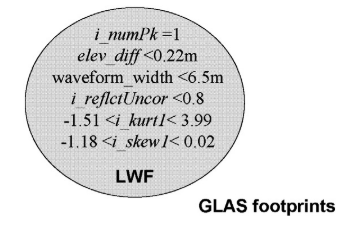

### Step 2: Slope calculation

#### Removing outliers

outliers = absolute value of residual exceeding 2.5 times of standard deviations

#### Fitting

Fitting an equation of water surface elevation vs latitude

H = A*x + B

where
H: the elevation
A: the slope
B: intercept
x: latitude